In [399]:
#Regresion Logistica
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

dataset = ["diabetes",
              "Enfermedad_Cardiaca"]

In [400]:
def LeerDatos(filename : str, header = True):
    if (header):
        data = pd.read_csv(filename + ".csv", sep ='\t', header = 0)
    else:
        data = pd.read_csv(filename+ ".csv", sep ='\t', header = None)
    data = data.sample(frac = 1)
    data = data.sort_values(data.columns[-1])
    #return np.array(data.iloc[:,:])
    return data.to_numpy()

In [401]:
diabetes = LeerDatos(dataset[0])
cardiaca = LeerDatos(dataset[1])

In [402]:
def Normalizar_Datos(data : np.array):
    #Excepto la ultima columna que indica la clase
    #normal = np.empty_like(data)
    for i in range (0,np.size(data[0])-1):
        media = np.mean(data[:,i])
        desvi =np.std(data[:,i])
        data[:,i] = (data[:,i] - media)/desvi
    return data

In [403]:
diabetes = Normalizar_Datos(diabetes)
cardiaca = Normalizar_Datos(cardiaca)

In [404]:
def Sigmoidal(X:np.array, theta:np.array):
    pot = X.dot(theta.T)
    return 1/(1+ np.exp(-pot))

In [405]:
def Calcular_Funcion_Costo(X: np.array, y:np.array, theta:np.array):
    #J(theta) = -1/m[ SUM( y* log(h(x)) + (1-y)*log(1-h(x)))
    m = np.size(X[:,0]) #numero de datos
    h = Sigmoidal(X, theta)
    return -1/m * ( np.sum( y.dot(np.log(h)) + (1-y).dot( np.log(1-h))) )

In [406]:
def Calcular_Gradiente(X:np.array, y:np.array, theta:np.array):
    #deriv = 1/m[ SUM (h(x)-y)x ]
    m = np.size(X[:,0]) #numero de datos
    h = Sigmoidal(X, theta) - y
    return np.dot(h, X) / m
    

In [407]:
def Gradiente_Descendiente(X: np.array, y:np.array, theta:np.array,
                          num_itera:int, tasa_apren:float):
    arr_costo = np.empty(num_itera, dtype =float)
    #Calculo con valor inicial
    for it in range(0, num_itera):
        arr_costo[it] = Calcular_Funcion_Costo(X, y, theta)
        theta = theta - (tasa_apren* Calcular_Gradiente(X, y, theta))
    return theta, arr_costo

In [408]:
def Calcular_Accuracy(X:np.array, y:np.array, theta:np.array):
    y_calc = np.around(Sigmoidal(X, theta))
    #y_accu = np.invert(np.bitwise_xor(y, y_calc))
    aciertos = 0
    for i in (y - y_calc):
        if (i == 0):
            aciertos += 1
    return aciertos/np.size(y)

In [409]:
def PromedioAccuracy(test:np.array, theta, k):
    accu = np.zeros(k)
    for i in range(0,k):
        accu[i] = Calcular_Accuracy(test[i][:,:-1], test[i][:,-1], theta)
    return accu.mean()

In [410]:
def Crear_k_folds(data:np.array, k:int):
    folds = []
    m = np.size(data[:,-1]) # numero de datos
    num_1 = np.count_nonzero(data[:,-1]) #numero clase 1
    num_0 = m - num_1 #numero clase 0
    new_num_1 = int(num_1/k) #Para conservar proporcion
    new_num_0 = int(num_0/k)
    print("0: " , new_num_0)
    print("1: " , new_num_1)
    fold0 = np.array_split(data[0:num_0], k)
    fold1 = np.array_split(data[num_0:], k)
    #print (fold0)
    for i in range (0,k):
        folds.append(np.vstack((fold0[i],fold1[i])))
    return folds

In [411]:
fold_diabetes = Crear_k_folds(diabetes, 3)
fold_cardiaca = Crear_k_folds(cardiaca, 3)

0:  166
1:  89
0:  46
1:  55


In [423]:
def CalculoParametros(folds:[], k:int, iteraciones, alpha):
    arr_costo = []
    arr_theta = []
    arr_test = []
    for test_i in range(0, k):
        test = folds[test_i] 
        train = np.zeros( (0,np.size(folds[0][0])) )
        for train_i in range (0, k):         
            if (train_i == test_i):
                continue
            else:
                train = np.vstack( (train,folds[train_i]) )
            
        costo = []
        X_train = train[:,:-1]
        y_train = train[:,-1]
        theta = np.zeros( (np.size(X_train[0])) )
    #s = Sigmoidal(X_train, theta)
    #c = Calcular_Funcion_Costo(X_train, y_train, theta)
        theta, costo = Gradiente_Descendiente(X_train, y_train, theta, iteraciones, alpha)
        arr_theta.append(theta)
        arr_costo.append(costo)
        arr_test.append(test)
      
    return theta, arr_costo, arr_test

In [426]:
def BusquedaParametros(folds:[], k):
    alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
    iteraciones = range(500,3501,500)
    arr_accu = np.empty( (len(alpha),len(iteraciones) ))
    for tasa in range(0,len(alpha)):
        for it in range(0, len(iteraciones)):
            theta, dummy, test = CalculoParametros(folds, k, iteraciones[it], alpha[tasa])
            arr_accu[tasa,it] = PromedioAccuracy(test, theta, k)
            
    return pd.DataFrame(arr_accu, index = alpha, columns = iteraciones)
            

In [427]:
BusquedaParametros(fold_diabetes, 3)

,500,1000,1500,2000,2500,3000,3500
0.01,0.739591,0.742180,0.749997,0.749997,0.749992,0.746086,0.744789
0.05,0.749992,0.743482,0.744779,0.746076,0.746076,0.746076,0.746076
0.10,0.743482,0.746076,0.746076,0.746076,0.746076,0.746076,0.746076
0.20,0.746076,0.746076,0.746076,0.746076,0.746076,0.746076,0.746076
0.30,0.746076,0.746076,0.746076,0.746076,0.746076,0.746076,0.746076
0.40,0.746076,0.746076,0.746076,0.746076,0.746076,0.746076,0.746076


In [435]:
BusquedaParametros(fold_cardiaca, 3)

,500,1000,1500,2000,2500,3000,3500
0.01,0.841584,0.858086,0.858086,0.854785,0.854785,0.854785,0.858086
0.05,0.854785,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086
0.10,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086
0.20,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086
0.30,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086
0.40,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086,0.858086


In [440]:
theta_diabetes, costo_diabetes, test_diabetes = CalculoParametros(fold_diabetes, 3, 2500, 0.05)
theta_cardiaca, costo_cardiaca, test_cardiaca = CalculoParametros(fold_cardiaca, 3, 1000, 0.20)
#costo_diabetes[0]

In [449]:
def PloteoCurvaCosto (arr: np.array, title):       
    #arr_theta.append(theta_grad[-1])
    #print (pd.DataFrame(arr))
    fig, ax = plt.subplots()
    #Ploteo de Curva
    scale = 1.0
    color = 'tab:blue'
    iteraciones = len(arr)
    plt.plot(range(0,iteraciones), arr, 'o', linewidth=1, markersize=2 )

    plt.title(title, {'fontsize':10})
    ax.set(xlim = [-10,iteraciones], ylim = (arr[-1]-0.1,arr[0]))
    ax.grid(True)
    plt.xlabel('Iteración')
    plt.ylabel('Costo')
    plt.show()

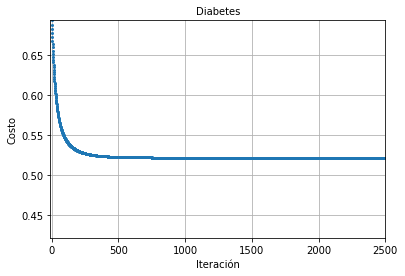

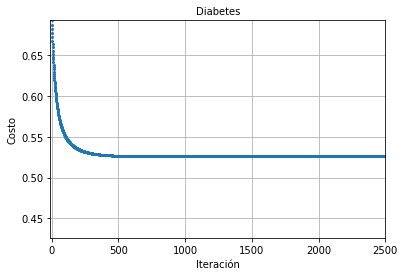

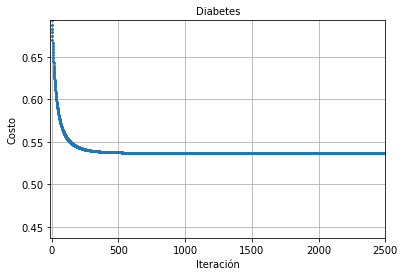

In [450]:
PloteoCurvaCosto(costo_diabetes[0], "Diabetes")
PloteoCurvaCosto(costo_diabetes[1], "Diabetes")
PloteoCurvaCosto(costo_diabetes[2], "Diabetes")

In [451]:
PromedioAccuracy(test_diabetes, theta_diabetes, 3)

0.7460758087281606

In [452]:
PromedioAccuracy(test_cardiaca, theta_cardiaca, 3)

0.8580858085808581

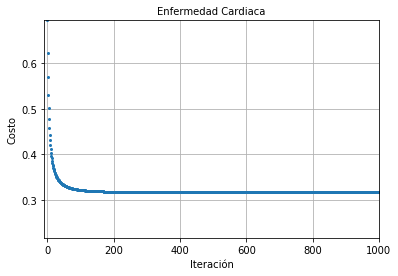

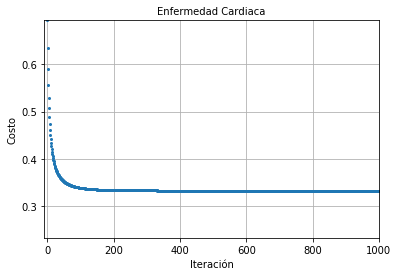

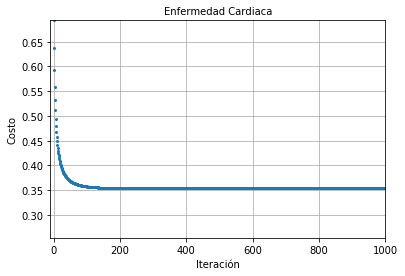

In [453]:
PloteoCurvaCosto(costo_cardiaca[0], "Enfermedad Cardiaca")
PloteoCurvaCosto(costo_cardiaca[1], "Enfermedad Cardiaca")
PloteoCurvaCosto(costo_cardiaca[2], "Enfermedad Cardiaca")
